<a href="https://colab.research.google.com/github/batmanvane/complex-systems-modeling/blob/main/notebooks/06_phase_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KeyboardInterrupt: 

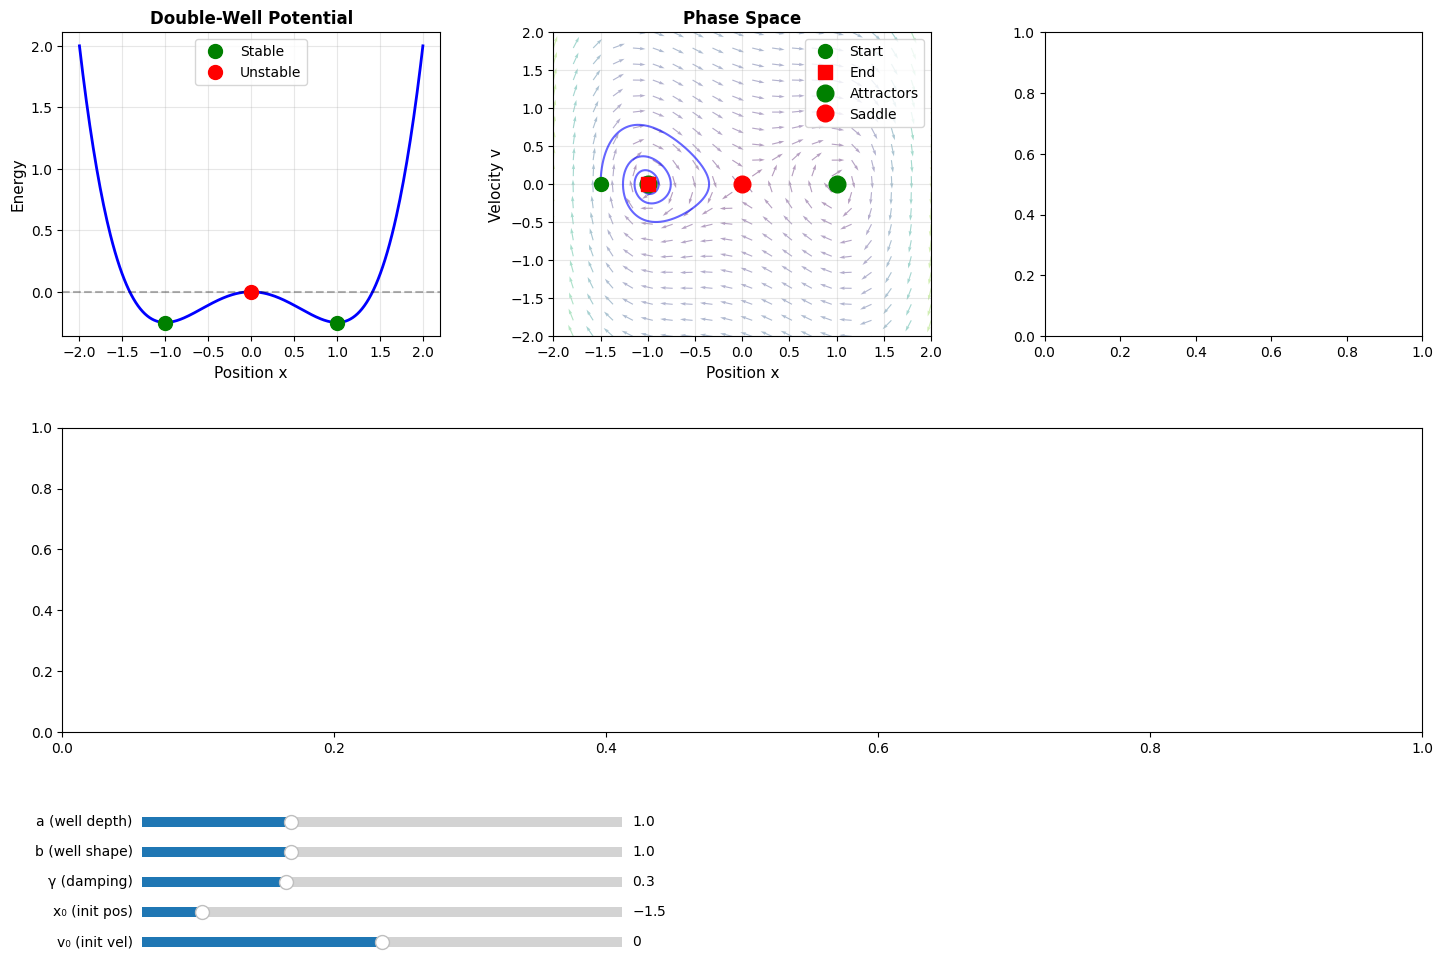

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.integrate import odeint
from matplotlib.patches import Circle

# Define the double-well potential
def potential(x, a=1, b=1):
    """Double-well potential: V(x) = -a*x^2/2 + b*x^4/4"""
    return -a * x**2 / 2 + b * x**4 / 4

def force(x, a=1, b=1):
    """Force: F = -dV/dx = a*x - b*x^3"""
    return a * x - b * x**3

# Equations of motion with damping
def equations(state, t, a, b, gamma):
    """
    state = [x, v] where x is position, v is velocity
    dx/dt = v
    dv/dt = -gamma*v + F(x) = -gamma*v + a*x - b*x^3
    """
    x, v = state
    dxdt = v
    dvdt = -gamma * v + force(x, a, b)
    return [dxdt, dvdt]

# Calculate basin of attraction
def basin_of_attraction(x_range, v_range, a, b, gamma, t_max=50):
    """Calculate which attractor each initial condition converges to"""
    basin = np.zeros((len(v_range), len(x_range)))

    # Find equilibrium points (attractors)
    x_eq = np.array([-np.sqrt(a/b), 0, np.sqrt(a/b)])

    for i, v0 in enumerate(v_range):
        for j, x0 in enumerate(x_range):
            # Integrate trajectory
            t = np.linspace(0, t_max, 1000)
            sol = odeint(equations, [x0, v0], t, args=(a, b, gamma))

            # Check final position
            x_final = sol[-1, 0]

            # Assign to closest attractor
            distances = np.abs(x_eq - x_final)
            basin[i, j] = np.argmin(distances)

    return basin

# Create the interactive plot
fig = plt.figure(figsize=(16, 10))

# Initial parameters
a_init = 1.0
b_init = 1.0
gamma_init = 0.3
x0_init = -1.5
v0_init = 0.0

# Create subplots
ax1 = plt.subplot(2, 3, 1)  # Potential
ax2 = plt.subplot(2, 3, 2)  # Phase space with trajectory
ax3 = plt.subplot(2, 3, 3)  # Basin of attraction
ax4 = plt.subplot(2, 3, (4, 6))  # Time evolution

plt.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.95, hspace=0.3, wspace=0.3)

def update_plots(a, b, gamma, x0, v0):
    """Update all plots with current parameters"""

    # Clear all axes
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    # Plot 1: Potential
    x_pot = np.linspace(-2, 2, 300)
    V = potential(x_pot, a, b)
    ax1.plot(x_pot, V, 'b-', linewidth=2)
    ax1.set_xlabel('Position x', fontsize=11)
    ax1.set_ylabel('Energy', fontsize=11)
    ax1.set_title('Double-Well Potential', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

    # Mark equilibrium points
    x_eq = np.array([-np.sqrt(a/b), 0, np.sqrt(a/b)])
    V_eq = potential(x_eq, a, b)
    ax1.plot(x_eq[[0, 2]], V_eq[[0, 2]], 'go', markersize=10, label='Stable')
    ax1.plot(x_eq[1], V_eq[1], 'ro', markersize=10, label='Unstable')
    ax1.legend()

    # Plot 2: Phase space trajectory
    t = np.linspace(0, 30, 2000)
    sol = odeint(equations, [x0, v0], t, args=(a, b, gamma))

    ax2.plot(sol[:, 0], sol[:, 1], 'b-', alpha=0.6, linewidth=1.5)
    ax2.plot(x0, v0, 'go', markersize=10, label='Start', zorder=5)
    ax2.plot(sol[-1, 0], sol[-1, 1], 'rs', markersize=10, label='End', zorder=5)

    # Plot vector field
    x_field = np.linspace(-2, 2, 20)
    v_field = np.linspace(-2, 2, 20)
    X, V = np.meshgrid(x_field, v_field)
    dX = V
    dV = -gamma * V + force(X, a, b)

    # Normalize vectors for better visualization
    M = np.sqrt(dX**2 + dV**2)
    M[M == 0] = 1
    dX_norm = dX / M
    dV_norm = dV / M

    ax2.quiver(X, V, dX_norm, dV_norm, M, alpha=0.4, cmap='viridis', scale=30)

    # Mark attractors
    ax2.plot(x_eq[[0, 2]], [0, 0], 'go', markersize=12, label='Attractors')
    ax2.plot(x_eq[1], 0, 'ro', markersize=12, label='Saddle')

    ax2.set_xlabel('Position x', fontsize=11)
    ax2.set_ylabel('Velocity v', fontsize=11)
    ax2.set_title('Phase Space', fontsize=12, fontweight='bold')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')

    # Plot 3: Basin of attraction
    x_basin = np.linspace(-2, 2, 100)
    v_basin = np.linspace(-2, 2, 100)
    basin = basin_of_attraction(x_basin, v_basin, a, b, gamma, t_max=30)

    extent = [x_basin[0], x_basin[-1], v_basin[0], v_basin[-1]]
    im = ax3.imshow(basin, extent=extent, origin='lower', cmap='RdYlBu',
                    aspect='auto', alpha=0.7, interpolation='bilinear')

    ax3.plot(x0, v0, 'ko', markersize=10, markeredgewidth=2,
             markerfacecolor='lime', label='Initial condition')
    ax3.plot(x_eq[[0, 2]], [0, 0], 'go', markersize=12, label='Attractors')
    ax3.plot(x_eq[1], 0, 'ro', markersize=12, label='Saddle')

    ax3.set_xlabel('Position x', fontsize=11)
    ax3.set_ylabel('Velocity v', fontsize=11)
    ax3.set_title('Basin of Attraction', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, color='white')

    # Plot 4: Time evolution
    ax4.plot(t, sol[:, 0], 'b-', linewidth=2, label='Position x(t)')
    ax4.plot(t, sol[:, 1], 'r-', linewidth=2, label='Velocity v(t)')
    ax4.set_xlabel('Time t', fontsize=11)
    ax4.set_ylabel('State', fontsize=11)
    ax4.set_title('Time Evolution', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)

    plt.draw()

# Create sliders
ax_a = plt.axes([0.15, 0.15, 0.3, 0.02])
ax_b = plt.axes([0.15, 0.12, 0.3, 0.02])
ax_gamma = plt.axes([0.15, 0.09, 0.3, 0.02])
ax_x0 = plt.axes([0.15, 0.06, 0.3, 0.02])
ax_v0 = plt.axes([0.15, 0.03, 0.3, 0.02])

slider_a = Slider(ax_a, 'a (well depth)', 0.1, 3.0, valinit=a_init, valstep=0.1)
slider_b = Slider(ax_b, 'b (well shape)', 0.1, 3.0, valinit=b_init, valstep=0.1)
slider_gamma = Slider(ax_gamma, 'γ (damping)', 0.0, 1.0, valinit=gamma_init, valstep=0.05)
slider_x0 = Slider(ax_x0, 'x₀ (init pos)', -2.0, 2.0, valinit=x0_init, valstep=0.1)
slider_v0 = Slider(ax_v0, 'v₀ (init vel)', -2.0, 2.0, valinit=v0_init, valstep=0.1)

def on_change(val):
    update_plots(slider_a.val, slider_b.val, slider_gamma.val,
                 slider_x0.val, slider_v0.val)

slider_a.on_changed(on_change)
slider_b.on_changed(on_change)
slider_gamma.on_changed(on_change)
slider_x0.on_changed(on_change)
slider_v0.on_changed(on_change)

# Initial plot
update_plots(a_init, b_init, gamma_init, x0_init, v0_init)

plt.suptitle('Interactive Double-Well Potential Phase Space Explorer',
             fontsize=14, fontweight='bold', y=0.98)

plt.show()

print("\n" + "="*70)
print("DOUBLE-WELL POTENTIAL PHASE SPACE EXPLORER")
print("="*70)
print("\nInstructions:")
print("- Adjust sliders to change system parameters")
print("- a: controls depth of potential wells")
print("- b: controls shape/width of potential wells")
print("- γ (gamma): damping coefficient")
print("- x₀, v₀: initial position and velocity")
print("\nFeatures:")
print("- Top left: Potential energy landscape")
print("- Top middle: Phase space with trajectory and vector field")
print("- Top right: Basin of attraction (which attractor you end up at)")
print("- Bottom: Time evolution of position and velocity")
print("\nTry different initial conditions to jump between attractors!")
print("="*70)